In [1]:
import os
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import pickle as pkl
import cv2
import numpy as np
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
import random

## Check TF GPU

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## Load csv and paths

In [4]:
csv_path = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train.csv"
train_path = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train_images/"
train_masks_path = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train_masks/"

In [5]:
n_w = 1600
n_h = 256

## Create a more balanced dataset with defects and extra 10% without defects

In [6]:
defective_csv = pd.read_csv(csv_path)
defective_img = [value for value in listdir(train_path) if value in list(defective_csv['ImageId'])]
nondefective_img = [value for value in listdir(train_path) if value not in list(defective_csv['ImageId'])]

In [7]:
print(len(defective_img))
print(len(nondefective_img))

6666
5902


In [8]:
idx_aux= np.random.permutation(len(nondefective_img))[0: int(len(defective_img)*0.1)-1]
defective_img = defective_img + [nondefective_img[value] for value in idx_aux]

In [9]:
len(defective_img)

7331

## Train, Test and Validation 

In [10]:
x_train, x_test = model_selection.train_test_split( defective_img, test_size=0.1, random_state=5)
x_train, x_valid = model_selection.train_test_split( x_train, test_size=0.1, random_state=5)

## Functions for inline (RAM) Y defect mask creation

In [11]:
def decode_pixels(pixels_str):
    """
    This function receives a list which contains the pixels as a space-separated code.
    For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask
    """
    
    pixels_encoded_list = pixels_str.split(' ')
    pixels_list = []
    for i in range(0, len(pixels_encoded_list), 2):
        # Add to the pixels list all the pixels encoded by the 2 digits
        pixels_list += range(
            int(pixels_encoded_list[i]) - 1,
            int(pixels_encoded_list[i]) + int(pixels_encoded_list[i + 1]) - 1,
        )
        
    # Return the decoded list    
    return pixels_list

In [12]:
n_class = 1
def make_mask(ImageId):
    
    y_out=defective_csv[defective_csv['ImageId'].eq(ImageId)]
    
    image_pixels = np.zeros((n_h, n_w,n_class), dtype=np.float32)

    for index, row in y_out.iterrows():

        # Generate the mask of the error type
        mask = np.zeros((n_h * n_w, 1), dtype=np.float32)
        mask[decode_pixels(row['EncodedPixels'])] = 1
        mask = mask.reshape(n_w, n_h)
        mask = mask.T
    
        # Update channel of the given error
        image_pixels [:,:,0] = np.logical_or(image_pixels [:,:,0],mask)
        
    return image_pixels

## Data generator for train

In [98]:
def flip(image, mask , vflip=False, hflip=False):
    '''
    Flip the image
    :param image: image to be processed
    :param vflip: whether to flip the image vertically
    :param hflip: whether to flip the image horizontally
    '''
    if hflip or vflip:
        if hflip and vflip:
            c = -1
        else:
            c = 0 if vflip else 1
        image = cv2.flip(image, flipCode=c)
        mask = cv2.flip(mask, flipCode=c)
    return image, mask

def rotate(image, mask, angle=90, scale=1.0):
    '''
    Rotate the image
    :param image: image to be processed
    :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
    :param scale: Isotropic scale factor.
    '''
    w = image.shape[1]
    h = image.shape[0]
    #rotate matrix
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
    #rotate
    image = cv2.warpAffine(image,M,(w,h))
    mask = cv2.warpAffine(mask,M,(w,h))
    return image, mask
    
def shift(image, mask, px, py):
    w = image.shape[1]
    h = image.shape[0]
    c = image.shape[2]
    
    img = np.zeros((h,w,c))
    m = np.zeros((h,w))   
    
    if (py > 0) and (px > 0):
        img[py:, px:, :] = image[:-py, :-px, :]
        m[py:, px:] = mask[:-py, :-px]
    elif (py < 0) and (px < 0):
        img[:py, :px, :] = image[-py:, -px:, :]
        m[:py, :px] = mask[-py:, -px:]
    elif (py > 0) and (px < 0):
        img[py:, :px, :] = image[:-py, -px:, :]
        m[py:, :px] = mask[:-py, -px:]
    elif (py < 0) and (px > 0):
        img[:py, px:, :] = image[-py:, :-px, :]
        m[:py, px:] = mask[-py:, :-px]
    
    return img, m

In [103]:
# Train Data Generator
def data_generator(ids, batch_size):
    Xs = []; ys = []
    
    aug_shift = np.random.randint(2, size=len(ids))
    aug_rot = np.random.randint(2, size=len(ids))
    aug_flip = np.random.randint(2, size=len(ids))
    
    i = 0
    
    while True:
        for id in ids:
            img = cv2.imread(train_path + id)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = img / 255.
            
            mask = make_mask(id)
            
            img=cv2.resize(img, (int(img.shape[1]/2),int(img.shape[0]/2)), interpolation = cv2.INTER_NEAREST)
            mask=cv2.resize(mask, (int(mask.shape[1]/2),int(mask.shape[0]/2)), interpolation = cv2.INTER_NEAREST)
            
            if aug_shift[i] == 1:
                img, mask = shift(img, mask,
                                  px=np.random.randint(low = -100,high = 100),
                                  py=np.random.randint(low = -100,high = 100))
            if aug_rot[i] == 1:
                img, mask = rotate(img, mask, angle=np.random.randint(90), scale=1 + (random.random()/10) )
            if aug_flip[i] == 1:
                img, mask = flip(img, mask, vflip=True, hflip=False)
            i+=1
            
            Xs.append(img); ys.append(mask)
            if len(Xs) == batch_size:
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                random.shuffle(ids)
                yield (X, y)

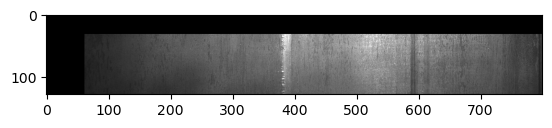

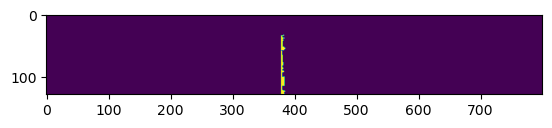

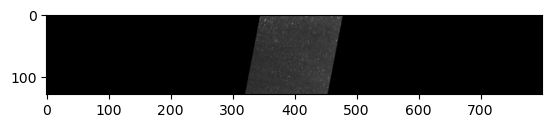

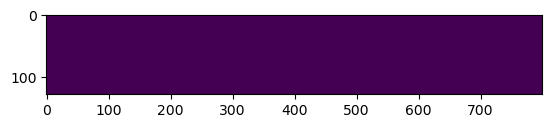

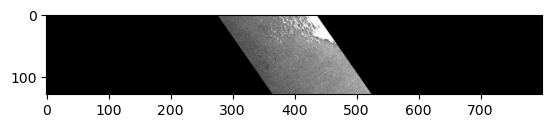

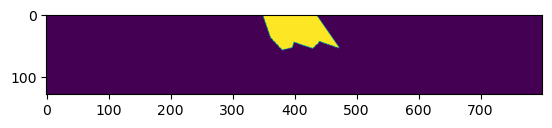

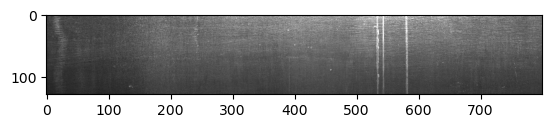

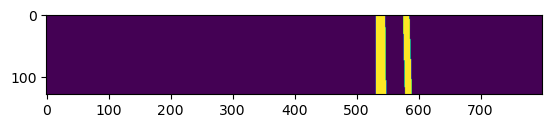

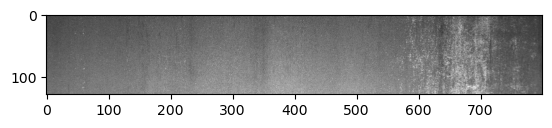

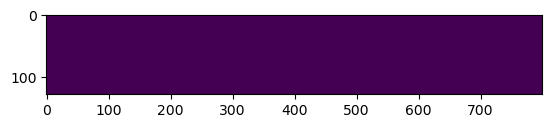

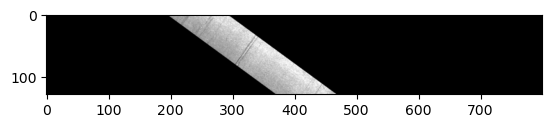

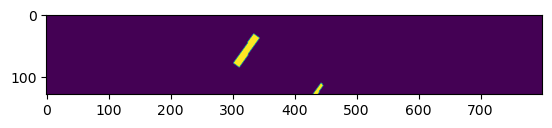

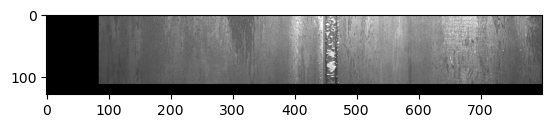

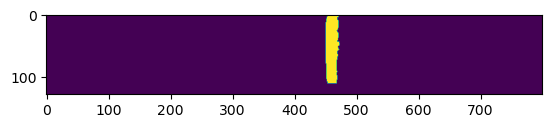

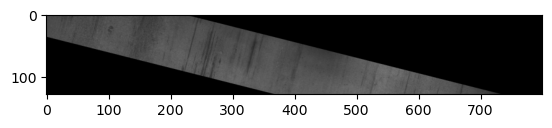

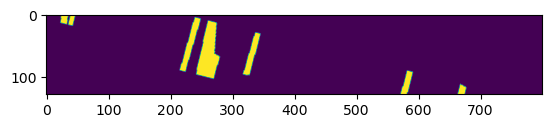

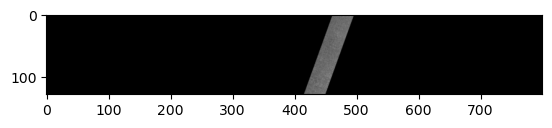

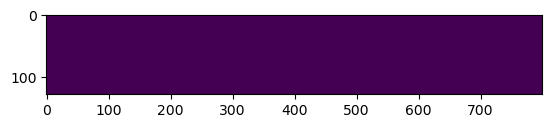

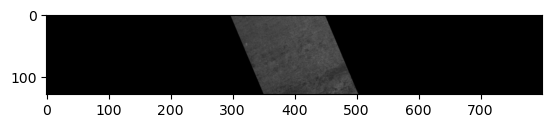

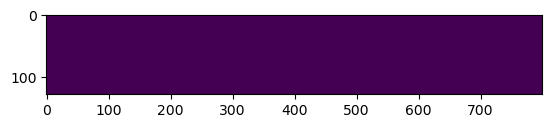

In [104]:
gen = data_generator(x_train,10)
for i in range(10):
    data =  next(gen)
    plt.imshow(data[0][0])
    plt.show()
    plt.imshow(data[1][0]*128)
    plt.show()

## U-Net Model with 4 sigmoid to detect presence or not of each class independently

#### We start with only  1 sigmoid for first training stages to detect only the presence of defect without classification

In [15]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Mitad
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same",kernel_initializer='he_normal')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same",kernel_initializer='he_normal')(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv1)
    
    return output_layer

input_layer = Input((128, 800, 3))
output_layer = build_model(input_layer, 32)

model = Model(input_layer, output_layer)

### Additional usefull metrics

In [16]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[:,:,index], y_pred[:,:,index])
    return dice

def dice_coef_nd(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return 2.*intersection, (np.sum(y_true_f)+np.sum(y_pred_f))

def dice_loss(y_true,y_pred):
    return (1 - dice_coef(y_true,y_pred))

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (1 - ((true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)))


In [17]:
optimizer = Adam()
#model.compile(loss=tversky, optimizer=Adam(learning_rate=0.001), metrics=[dice_coef])
#model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[dice_coef])
model.compile(optimizer, dice_loss, metrics=[dice_coef])

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 800, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 800, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 400, 64)  0           conv2d_1[0][0]                   
_______________________________________________________________________________________

### Model Train

In [20]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 10
batch_size = 16

train_generator = data_generator(x_train, batch_size)
validation_generator = data_generator(x_valid, batch_size)

train_steps_per_epoch=int(len(x_train)/batch_size)
validation_steps_per_epoch=int(len(x_valid)/batch_size)

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = validation_steps_per_epoch
                    #callbacks=[early_stopping, model_checkpoint, reduce_lr])
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[16,256,64,400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/functional_1/dropout_6/dropout/Mul (defined at <ipython-input-20-41b903461344>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_3202]

Function call stack:
train_function


In [50]:
model.save_weights('./weights/pre3/model_pre_v3')

In [51]:
model.save('./model/pre3/model_pre3')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/pre3/model_pre3\assets


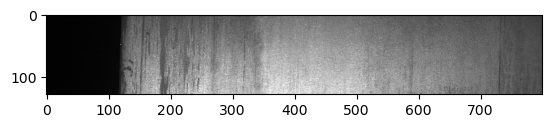

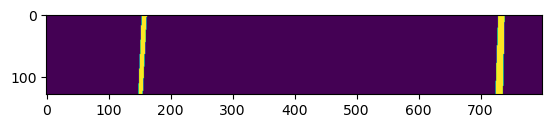

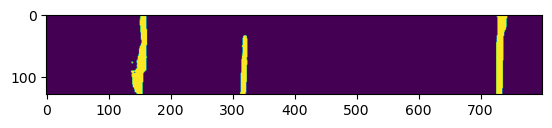

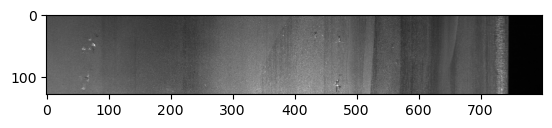

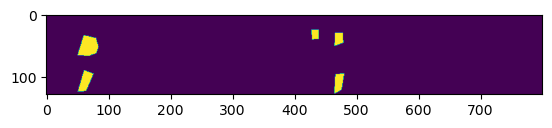

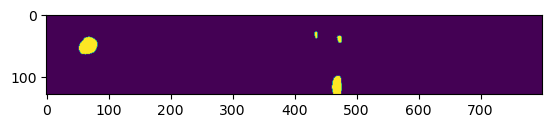

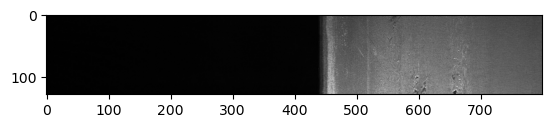

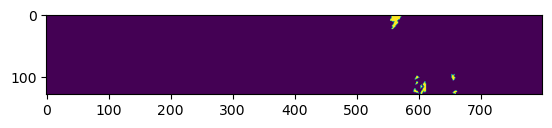

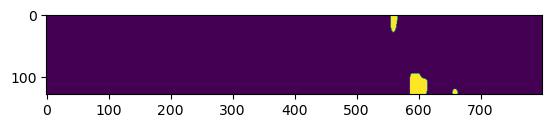

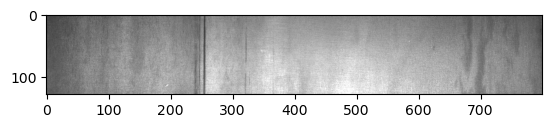

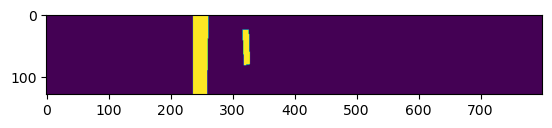

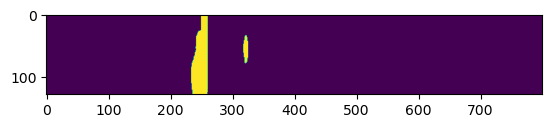

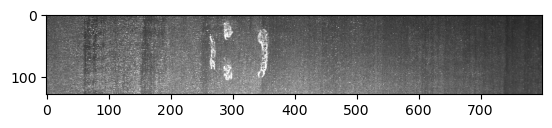

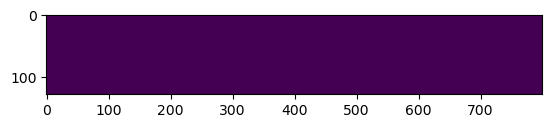

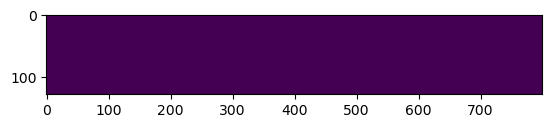

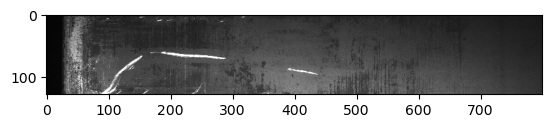

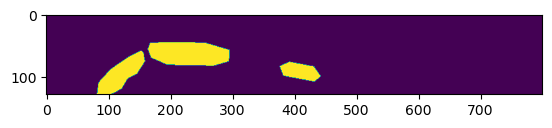

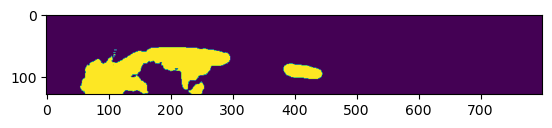

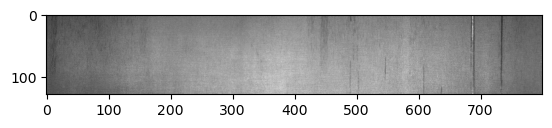

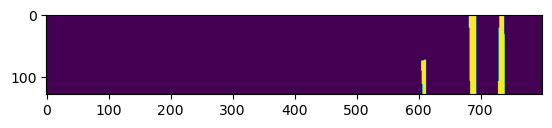

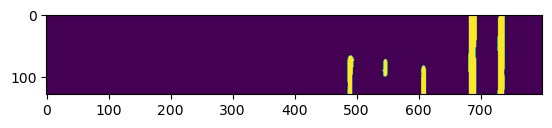

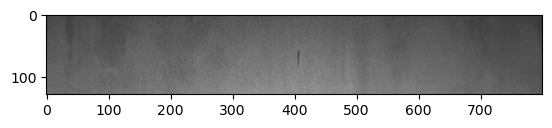

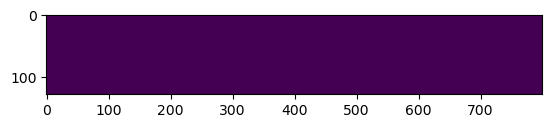

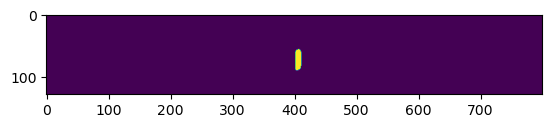

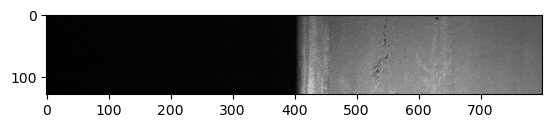

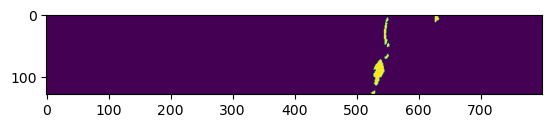

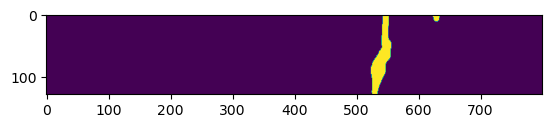

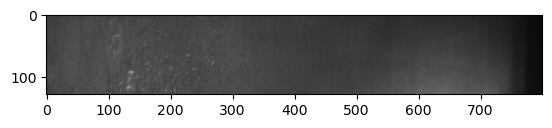

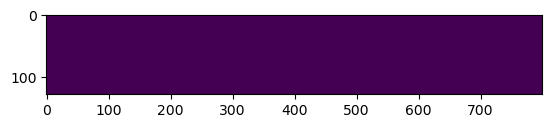

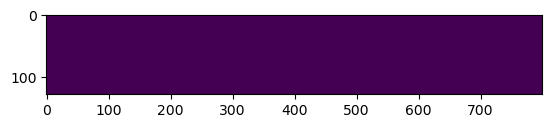

In [49]:
test_generator = data_generator(x_test,batch_size=1)

for i in range(10):
    data_test = next(test_generator)
    prediction=model.predict(data_test[0])
    plt.imshow(data_test[0][0])
    plt.show()
    plt.imshow(data_test[1][0]*128)
    plt.show()
    plt.imshow(prediction[0]*128)
    plt.show()


